# DataTables, Indexes, Pandas, and Seaborn

## Some useful (free) resources

Introductory:

* [Getting started with Python for research](https://github.com/TiesdeKok/LearnPythonforResearch), a gentle introduction to Python in data-intensive research.

* [A Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/index.html), by Jake VanderPlas, another quick Python intro (with notebooks).

Core Pandas/Data Science books:

* [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/), by Jake VanderPlas.

* [Python for Data Analysis, 2nd Edition](http://proquest.safaribooksonline.com/book/programming/python/9781491957653), by  Wes McKinney, creator of Pandas. [Companion Notebooks](https://github.com/wesm/pydata-book)

* [Effective Pandas](https://github.com/TomAugspurger/effective-pandas), a book by Tom Augspurger, core Pandas developer.


Complementary resources:

* [An introduction to "Data Science"](https://github.com/stefanv/ds_intro), a collection of Notebooks by BIDS' [Stéfan Van der Walt](https://bids.berkeley.edu/people/st%C3%A9fan-van-der-walt).

* [Effective Computation in Physics](http://proquest.safaribooksonline.com/book/physics/9781491901564), by Kathryn D. Huff; Anthony Scopatz. [Notebooks to accompany the book](https://github.com/physics-codes/seminar). Don't be fooled by the title, it's a great book on modern computational practices with very little that's physics-specific.


OK, let's load and configure some of our core libraries (as an aside, you can find a nice visual gallery of available matplotlib sytles [here](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html)).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

## Getting the Data

https://www.ssa.gov/OACT/babynames/index.html

https://www.ssa.gov/data

As we saw before, we can download data from the internet with Python, and do so only if needed:

In [2]:
import requests
from pathlib import Path

namesbystate_path = Path('namesbystate.zip')
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'

if not namesbystate_path.exists():
    print('Downloading...', end=' ')
    resp = requests.get(data_url)
    with namesbystate_path.open('wb') as f:
        f.write(resp.content)
    print('Done!')

Let's use Python to understand how this data is laid out:

In [3]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')
print([f.filename for f in zf.filelist])

['DC.TXT', 'DE.TXT', 'FL.TXT', 'GA.TXT', 'HI.TXT', 'IA.TXT', 'ID.TXT', 'IL.TXT', 'IN.TXT', 'KS.TXT', 'KY.TXT', 'LA.TXT', 'MA.TXT', 'MD.TXT', 'ME.TXT', 'MI.TXT', 'MN.TXT', 'MO.TXT', 'MS.TXT', 'MT.TXT', 'NC.TXT', 'ND.TXT', 'NE.TXT', 'NH.TXT', 'NJ.TXT', 'NM.TXT', 'NV.TXT', 'NY.TXT', 'OH.TXT', 'OK.TXT', 'OR.TXT', 'PA.TXT', 'RI.TXT', 'SC.TXT', 'SD.TXT', 'TN.TXT', 'TX.TXT', 'UT.TXT', 'VA.TXT', 'VT.TXT', 'WA.TXT', 'WI.TXT', 'WV.TXT', 'WY.TXT', 'AK.TXT', 'AL.TXT', 'AR.TXT', 'AZ.TXT', 'CA.TXT', 'CO.TXT', 'CT.TXT', 'StateReadMe.pdf']


We can pull the PDF readme to view it, but let's operate with the rest of the data in its compressed state:

In [4]:
zf.extract('StateReadMe.pdf')

'/Users/fperez/teach/ds100/sp18-dev/lectures/lec03/StateReadMe.pdf'

Let's have a look at the California data, it should give us an idea about the structure of the whole thing:

In [5]:
ca_name = 'CA.TXT'
with zf.open(ca_name) as f:
    for i in range(10):
        print(f.readline().rstrip().decode())

CA,F,1910,Mary,295
CA,F,1910,Helen,239
CA,F,1910,Dorothy,220
CA,F,1910,Margaret,163
CA,F,1910,Frances,134
CA,F,1910,Ruth,128
CA,F,1910,Evelyn,126
CA,F,1910,Alice,118
CA,F,1910,Virginia,101
CA,F,1910,Elizabeth,93


This is equivalent (on macOS or Linux) to extracting the full `CA.TXT` file to disk and then using the `head` command (if you're on Windows, don't try to run the cell below):

In [6]:
zf.extract(ca_name)
!head {ca_name}

In [7]:
!echo {ca_name}

CA.TXT


A couple of practical comments:

* The above is using special tricks in IPython that let you call operating system commands via `!cmd`, and that expand Python variables in such commands with the `{var}` syntax. You can find more about IPython's special tricks [in this tutorial](https://github.com/ipython/ipython-in-depth/blob/master/examples/IPython%20Kernel/Beyond%20Plain%20Python.ipynb).

* `head` doesn't work on Windows, though there are equivalent Windows commands. But by using Python code, even if it's a little bit more verbose, we have a 100% portable solution.

* If the `CA.TXT` file was huge, it would be wasteful to write it all to disk only to look at the start of the file.

The last point is an important, and general theme of this course: we need to learn how to operate with data only on an as-needed basis, because there are many situations in the real world where we can't afford to brute-force 'download all the things'.

Let's remove the `CA.TXT` file to make sure we keep working with our compressed data, as if we couldn't extract it:

In [8]:
import os; os.unlink(ca_name)

## Question 1: What was the most popular name in CA last year?

In [9]:
import pandas as pd

field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    ca = pd.read_csv(fh, header=None, names=field_names)
ca.head()

State Sex  Year      Name  Count
0    CA   F  1910      Mary    295
1    CA   F  1910     Helen    239
2    CA   F  1910   Dorothy    220
3    CA   F  1910  Margaret    163
4    CA   F  1910   Frances    134

### Slicing

A Pandas DataFrame is, by default, indexed by **column name**:

In [10]:
ca['Count'].head()

0    295
1    239
2    220
3    163
4    134
Name: Count, dtype: int64

In [11]:
ca[0:3]

State Sex  Year     Name  Count
0    CA   F  1910     Mary    295
1    CA   F  1910    Helen    239
2    CA   F  1910  Dorothy    220

In [12]:
#ca[0]

In [13]:
ca.iloc[:3, -2:]

Name  Count
0     Mary    295
1    Helen    239
2  Dorothy    220

In [14]:
ca.loc[0:3, 'State']

0    CA
1    CA
2    CA
3    CA
Name: State, dtype: object

In [15]:
ca['Name'].head()

0        Mary
1       Helen
2     Dorothy
3    Margaret
4     Frances
Name: Name, dtype: object

In [16]:
ca[['Name']].head()

Name
0      Mary
1     Helen
2   Dorothy
3  Margaret
4   Frances

For more on `loc` and `iloc`, see the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/indexing.html#different-choices-for-indexing).

Now, what is the leftmost column?

In [17]:
emails = ca.head()
emails.index = ['a@gmail.com', 'b@gmail.com', 'c@gmail.com', 'd@gmail.com', 'e@gmail.com']
emails

State Sex  Year      Name  Count
a@gmail.com    CA   F  1910      Mary    295
b@gmail.com    CA   F  1910     Helen    239
c@gmail.com    CA   F  1910   Dorothy    220
d@gmail.com    CA   F  1910  Margaret    163
e@gmail.com    CA   F  1910   Frances    134

In [18]:
emails.loc['b@gmail.com':'d@gmail.com', 'Year':'Name']

Year      Name
b@gmail.com  1910     Helen
c@gmail.com  1910   Dorothy
d@gmail.com  1910  Margaret

In [19]:
emails.iloc[0:3]

State Sex  Year     Name  Count
a@gmail.com    CA   F  1910     Mary    295
b@gmail.com    CA   F  1910    Helen    239
c@gmail.com    CA   F  1910  Dorothy    220

In [20]:
ca.head()

State Sex  Year      Name  Count
0    CA   F  1910      Mary    295
1    CA   F  1910     Helen    239
2    CA   F  1910   Dorothy    220
3    CA   F  1910  Margaret    163
4    CA   F  1910   Frances    134

In [21]:
(ca['Year'] == 2016).head()

0    False
1    False
2    False
3    False
4    False
Name: Year, dtype: bool

In [22]:
ca[ca['Year'] == 2016].tail()

State Sex  Year     Name  Count
367926    CA   M  2016   Zekiel      5
367927    CA   M  2016    Ziyad      5
367928    CA   M  2016  Zorawar      5
367929    CA   M  2016     Zyan      5
367930    CA   M  2016     Zyir      5

### Sorting

In [23]:
ca_sorted = ca[ca['Year'] == 2016]
ca_sorted.sort_values('Count', ascending=False).tail(10)

State Sex  Year     Name  Count
217131    CA   F  2016  Maleena      5
217132    CA   F  2016   Maleny      5
217133    CA   F  2016   Maleya      5
217134    CA   F  2016     Mali      5
217135    CA   F  2016   Malika      5
217136    CA   F  2016  Manreet      5
217137    CA   F  2016  Manuela      5
217138    CA   F  2016  Marilee      5
217139    CA   F  2016    Marya      5
367930    CA   M  2016     Zyir      5

## Recap: anatomy of a DataFrame

Let's look again at the data we have for California:

In [24]:
ca.head()

State Sex  Year      Name  Count
0    CA   F  1910      Mary    295
1    CA   F  1910     Helen    239
2    CA   F  1910   Dorothy    220
3    CA   F  1910  Margaret    163
4    CA   F  1910   Frances    134

We can get a sense for the shape of our data:

In [25]:
ca.shape

(367931, 5)

In [26]:
ca.size  # rows x columns

1839655

Pandas will give us a summary overview of the *numerical* data in the DataFrame:

In [27]:
ca.describe()

Year          Count
count  367931.000000  367931.000000
mean     1982.117169      81.850034
std        25.928678     303.826855
min      1910.000000       5.000000
25%      1966.000000       7.000000
50%      1988.000000      13.000000
75%      2003.000000      39.000000
max      2016.000000    8263.000000

And let's look at the *structure* of the DataFrame:

In [28]:
ca.index

RangeIndex(start=0, stop=367931, step=1)

In [29]:
emails

State Sex  Year      Name  Count
a@gmail.com    CA   F  1910      Mary    295
b@gmail.com    CA   F  1910     Helen    239
c@gmail.com    CA   F  1910   Dorothy    220
d@gmail.com    CA   F  1910  Margaret    163
e@gmail.com    CA   F  1910   Frances    134

In [30]:
emails.index

Index(['a@gmail.com', 'b@gmail.com', 'c@gmail.com', 'd@gmail.com',
       'e@gmail.com'],
      dtype='object')

In [31]:
emails.index.name = 'Email'
emails

State Sex  Year      Name  Count
Email                                       
a@gmail.com    CA   F  1910      Mary    295
b@gmail.com    CA   F  1910     Helen    239
c@gmail.com    CA   F  1910   Dorothy    220
d@gmail.com    CA   F  1910  Margaret    163
e@gmail.com    CA   F  1910   Frances    134

The columns can also be named, since the `.columns` attribute is an Index too:

In [32]:
emails.columns

Index(['State', 'Sex', 'Year', 'Name', 'Count'], dtype='object')

In [33]:
emails.columns.name = 'Fields'
emails

Fields      State Sex  Year      Name  Count
Email                                       
a@gmail.com    CA   F  1910      Mary    295
b@gmail.com    CA   F  1910     Helen    239
c@gmail.com    CA   F  1910   Dorothy    220
d@gmail.com    CA   F  1910  Margaret    163
e@gmail.com    CA   F  1910   Frances    134

Note that it's possible to have an index with integers that do *not* correspond to the default `[0, 1, 2, ...]` positional order:

In [34]:
numbers = emails.copy()
numbers.index = [5,4,3,2,1]
numbers.index.name = 'order'
numbers.columns.name = None  # letremove name for column index for clarity
numbers

State Sex  Year      Name  Count
order                                 
5        CA   F  1910      Mary    295
4        CA   F  1910     Helen    239
3        CA   F  1910   Dorothy    220
2        CA   F  1910  Margaret    163
1        CA   F  1910   Frances    134

Now, the number `1` can be used to access the positionally second row, with `iloc`:

In [35]:
numbers.iloc[1]

State       CA
Sex          F
Year      1910
Name     Helen
Count      239
Name: 4, dtype: object

Or the row *labeled* `1`, which in this case happens to be the last one:

In [36]:
numbers.loc[1]

State         CA
Sex            F
Year        1910
Name     Frances
Count        134
Name: 1, dtype: object

Integer/positional with `iloc` vs labeled with `loc` can be used also for multiple rows/columns:

In [37]:
numbers.iloc[:3, -2:]

Name  Count
order                
5         Mary    295
4        Helen    239
3      Dorothy    220

These two diagrams illustrate the various pieces that compose a Pandas `Series`:

![](pandas-struct-series.png)

and a `DataFrame`, which is a set of `Series`  that share a common index:

![](pandas-struct-df.png)

## Question 2: Most popular names in all states for each year?

### Put all DFs together

Again, we'll work off our in-memory, compressed zip archive and pull the data out of it into Pandas DataFrames without ever putting it all on disk. We can see how large the compressed and uncompressed data is:

In [38]:
sum(f.file_size for f in zf.filelist)/1_000_000

120.463088

In [39]:
sum(f.compress_size for f in zf.filelist)/1_000_000

24.900652

In [40]:
__/_  # divide the next-previous result by the previous one

4.837748344902776

First, notice that the in-memory compressed archive is not alphabetically sorted:

In [41]:
zf.filelist[:5]

[<ZipInfo filename='DC.TXT' compress_type=deflate external_attr=0x20 file_size=1120459 compress_size=225154>,
 <ZipInfo filename='DE.TXT' compress_type=deflate external_attr=0x20 file_size=642699 compress_size=127631>,
 <ZipInfo filename='FL.TXT' compress_type=deflate external_attr=0x20 file_size=4057116 compress_size=848854>,
 <ZipInfo filename='GA.TXT' compress_type=deflate external_attr=0x20 file_size=3616566 compress_size=742801>,
 <ZipInfo filename='HI.TXT' compress_type=deflate external_attr=0x20 file_size=1086102 compress_size=216102>]

But we can pull them out in alphabetical order with the Python `sorted` function, sorting by filename:

In [42]:
%%time
states = []

for f in sorted(zf.filelist, key=lambda x:x.filename):
    if not f.filename.endswith('.TXT'):
        continue
    with zf.open(f) as fh:
        states.append(pd.read_csv(fh, header=None, names=field_names))

CPU times: user 2.42 s, sys: 475 ms, total: 2.9 s
Wall time: 2.92 s


Now, we create a single DataFrame by concatenating these into one:

In [43]:
baby_names = pd.concat(states).reset_index(drop=True)
baby_names.head()

State Sex  Year      Name  Count
0    AK   F  1910      Mary     14
1    AK   F  1910     Annie     12
2    AK   F  1910      Anna     10
3    AK   F  1910  Margaret      8
4    AK   F  1910     Helen      7

In [44]:
baby_names.shape

(5838786, 5)

### Group by state and year

In [45]:
baby_names[
    (baby_names['State'] == 'CA')
    & (baby_names['Year'] == 1995)
    & (baby_names['Sex'] == 'M')
].head()

# Now I could write 3 nested for loops...

State Sex  Year         Name  Count
675533    CA   M  1995       Daniel   5003
675534    CA   M  1995      Michael   4783
675535    CA   M  1995         Jose   4572
675536    CA   M  1995  Christopher   4096
675537    CA   M  1995        David   4029

In [46]:
%%time
baby_names.groupby('State').size().head()

CPU times: user 162 ms, sys: 84.6 ms, total: 246 ms
Wall time: 243 ms


State
AK     27624
AL    130297
AR     98853
AZ    110866
CA    367931
dtype: int64

In [47]:
state_counts = baby_names.loc[:, ('State', 'Count')]
state_counts.head()

State  Count
0    AK     14
1    AK     12
2    AK     10
3    AK      8
4    AK      7

In [48]:
sg = state_counts.groupby('State')
sg

## Pause: what is a `DataFrameGroupBy` object?

See [companion notebook](03-groupby-notes.ipynb), and come back...

---

## You're back. Let's continue with our question

(Finding the most popular baby names for all states and years).

In [49]:
state_counts.groupby('State').sum().head()

Count
State          
AK       424852
AL      5773719
AR      3408590
AZ      3532872
CA     30115165

    state_counts.group('State', np.sum)

In [50]:
import numpy as np
state_counts.groupby('State').agg(np.sum).head()

Count
State          
AK       424852
AL      5773719
AR      3408590
AZ      3532872
CA     30115165

Using a custom function to aggregate.

Equivalent to this code from Data 8:

    state_and_groups.group('State', np.sum)

### Grouping by multiple columns

In [51]:
baby_names.groupby(['State', 'Year']).size().head(3)

State  Year
AK     1910    16
       1911    11
       1912    20
dtype: int64

In [52]:
baby_names.groupby(['State', 'Year']).sum().head(3)

Count
State Year       
AK    1910    115
      1911     84
      1912    141

In [53]:
ak1910 = baby_names.query("State=='AK' and Year==1910")
print(ak1910.shape)
ak1910

(16, 5)


State Sex  Year      Name  Count
0        AK   F  1910      Mary     14
1        AK   F  1910     Annie     12
2        AK   F  1910      Anna     10
3        AK   F  1910  Margaret      8
4        AK   F  1910     Helen      7
5        AK   F  1910     Elsie      6
6        AK   F  1910      Lucy      6
7        AK   F  1910   Dorothy      5
14201    AK   M  1910      John      8
14202    AK   M  1910     James      7
14203    AK   M  1910      Paul      6
14204    AK   M  1910    Robert      6
14205    AK   M  1910      Carl      5
14206    AK   M  1910    Edward      5
14207    AK   M  1910    George      5
14208    AK   M  1910   William      5

In [54]:
baby_names.groupby(['State', 'Year', 'Sex']).sum().head()

Count
State Year Sex       
AK    1910 F       68
           M       47
      1911 F       44
           M       40
      1912 F       82

In [55]:
%%time
def first(series):
    '''Returns the first value in the series.'''
    return series.iloc[0]

most_popular_names = (
    baby_names
    .groupby(['State', 'Year', 'Sex'])
    .agg(first)
)
most_popular_names.head()

CPU times: user 913 ms, sys: 302 ms, total: 1.21 s
Wall time: 1.22 s


This creates a multilevel index. It is quite complex, but just know that you can still slice:

In [56]:
most_popular_names[most_popular_names['Name'] == 'Samuel']

Name  Count
State Year Sex               
ID    2010 M    Samuel    114

And you can use `.loc` as so:

In [57]:
most_popular_names.loc['CA', 1997, 'M']

Name     Daniel
Count      4452
Name: (CA, 1997, M), dtype: object

In [58]:
most_popular_names.loc['CA', 1995:2000, 'M']

Name  Count
State Year Sex               
CA    1995 M    Daniel   5003
      1996 M    Daniel   4705
      1997 M    Daniel   4452
      1998 M    Daniel   4317
      1999 M    Daniel   4352
      2000 M    Daniel   4339

## Question 3: Can I deduce birth sex from the last letter of a person’s name?

### Compute last letter of each name

In [59]:
baby_names.head()

State Sex  Year      Name  Count
0    AK   F  1910      Mary     14
1    AK   F  1910     Annie     12
2    AK   F  1910      Anna     10
3    AK   F  1910  Margaret      8
4    AK   F  1910     Helen      7

In [60]:
baby_names['Name'].apply(len).head()

0    4
1    5
2    4
3    8
4    5
Name: Name, dtype: int64

In [61]:
baby_names['Name'].str.len().head()

0    4
1    5
2    4
3    8
4    5
Name: Name, dtype: int64

In [62]:
baby_names['Name'].str[-1].head()

0    y
1    e
2    a
3    t
4    n
Name: Name, dtype: object

To add column to dataframe:

In [63]:
baby_names['Last letter'] = baby_names['Name'].str[-1]
baby_names.head()

State Sex  Year      Name  Count Last letter
0    AK   F  1910      Mary     14           y
1    AK   F  1910     Annie     12           e
2    AK   F  1910      Anna     10           a
3    AK   F  1910  Margaret      8           t
4    AK   F  1910     Helen      7           n

### Group by last letter and sex

In [64]:
letter_counts = (baby_names
                 .loc[:, ('Sex', 'Count', 'Last letter')]
                 .groupby(['Last letter', 'Sex'])
                 .sum())
letter_counts.head()

Count
Last letter Sex          
a           F    49128453
            M     1585024
b           F        9666
            M     1369244
c           F       18211

### Visualize our result

Use .plot to get some basic plotting functionality:

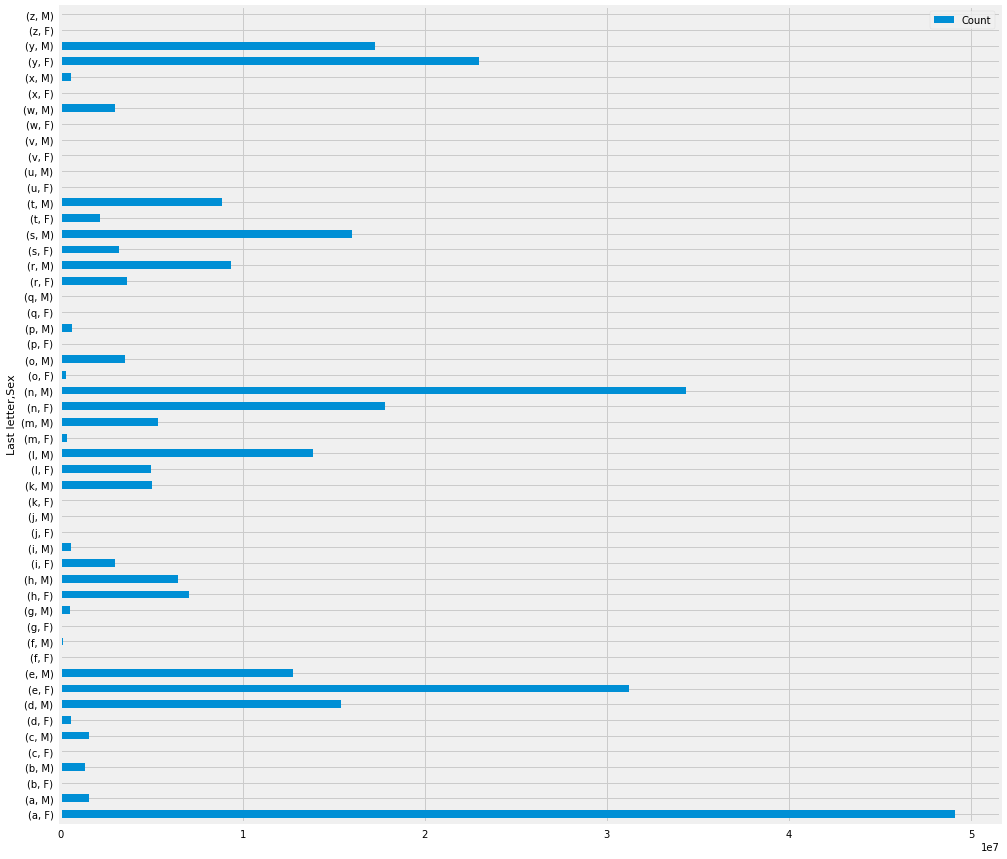

In [65]:
# Why is this not good?
letter_counts.plot.barh(figsize=(15, 15));

Reading the docs shows me that pandas will make one set of bars for each column in my table. How do I move each sex into its own column? I have to use pivot:

In [66]:
# For comparison, the group above:
# letter_counts = (baby_names
#                  .loc[:, ('Sex', 'Count', 'Last letter')]
#                  .groupby(['Last letter', 'Sex'])
#                  .sum())

last_letter_pivot = baby_names.pivot_table(
    index='Last letter', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)
last_letter_pivot.head()

Sex                 F         M
Last letter                    
a            49128453   1585024
b                9666   1369244
c               18211   1565621
d              564804  15423771
e            31212081  12778932

---

### Slides: GroupBy/Pivot comparison slides and Quiz

At this point, I highly recommend [this very nice tutorial on Pivot Tables](http://pbpython.com/pandas-pivot-table-explained.html).

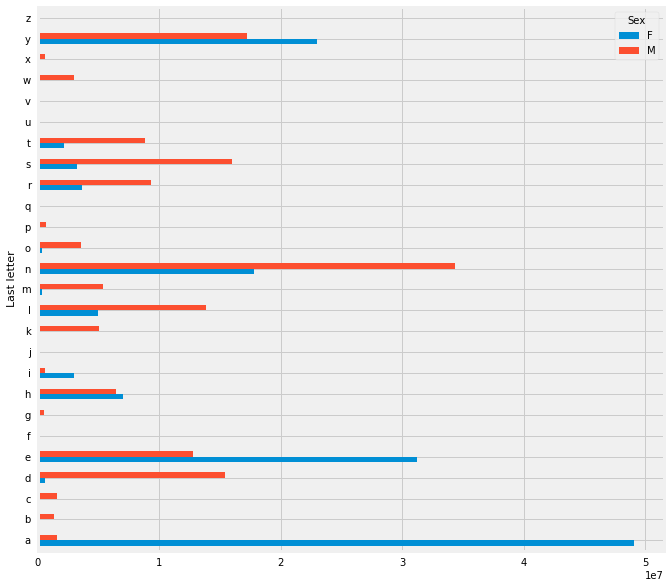

In [67]:
last_letter_pivot.plot.barh(figsize=(10, 10));

Why is this still not ideal?

- Plotting raw counts
- Not sorted by any order

In [68]:
totals = last_letter_pivot['F'] + last_letter_pivot['M']

last_letter_props = pd.DataFrame({
    'F': last_letter_pivot['F'] / totals,
    'M': last_letter_pivot['M'] / totals,
}).sort_values('M')
last_letter_props.head()

F         M
Last letter                    
a            0.968746  0.031254
i            0.830335  0.169665
e            0.709510  0.290490
z            0.645210  0.354790
y            0.571341  0.428659

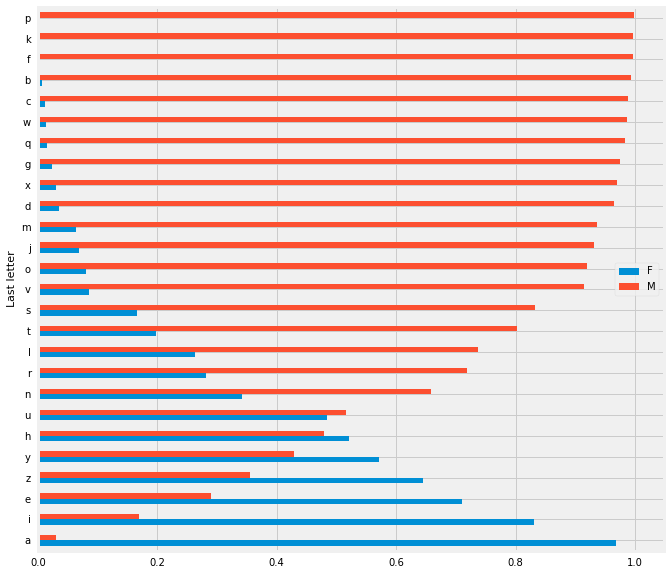

In [69]:
last_letter_props.plot.barh(figsize=(10, 10));

What do you notice?

## Seaborn

Let's use a subset of our dataset for now:

In [70]:
ca_and_ny = baby_names[
    (baby_names['Year'] == 2016)
    & (baby_names['State'].isin(['CA', 'NY']))
].reset_index(drop=True)
ca_and_ny.head()

State Sex  Year      Name  Count Last letter
0    CA   F  2016       Mia   2785           a
1    CA   F  2016    Sophia   2747           a
2    CA   F  2016      Emma   2592           a
3    CA   F  2016    Olivia   2533           a
4    CA   F  2016  Isabella   2350           a

Note that the same thing can be computed as a query:

In [71]:
baby_names.query("Year==2016 and State in ['CA', 'NY']").reset_index(drop=True).head()

State Sex  Year      Name  Count Last letter
0    CA   F  2016       Mia   2785           a
1    CA   F  2016    Sophia   2747           a
2    CA   F  2016      Emma   2592           a
3    CA   F  2016    Olivia   2533           a
4    CA   F  2016  Isabella   2350           a

We actually don't need to do any pivoting / grouping for seaborn!

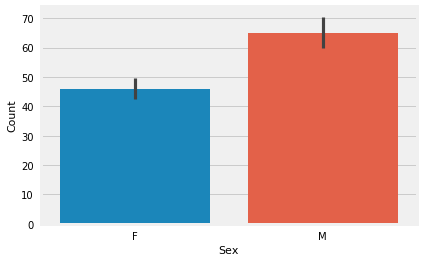

In [72]:
sns.barplot(x='Sex', y='Count', data=ca_and_ny);

Note the automatic confidence interval generation. Many seaborn functions have these nifty statistical features.

(It actually isn't useful for our case since we have a census. It also makes seaborn functions run slower since they use bootstrap to generate the CI, so sometimes you want to turn it off.)

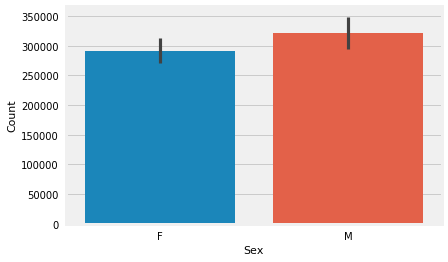

In [73]:
sns.barplot(x='Sex', y='Count', data=ca_and_ny, estimator=sum);

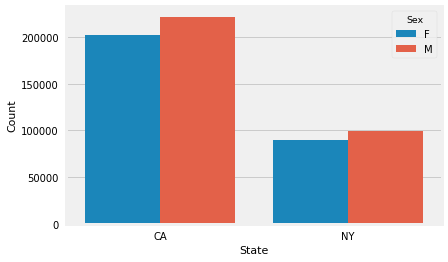

In [74]:
sns.barplot(x='State', y='Count', hue='Sex', data=ca_and_ny, ci=None, estimator=sum);

Going to work with tips data just to demonstrate:

In [75]:
tips = sns.load_dataset("tips")
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

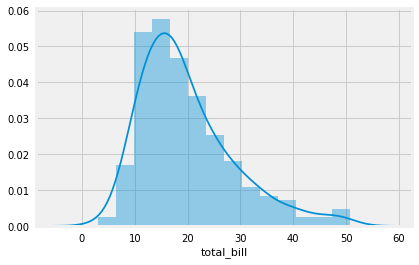

In [76]:
sns.distplot(tips['total_bill']);

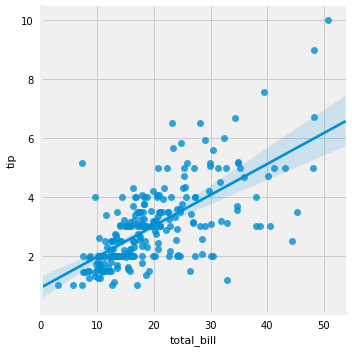

In [77]:
sns.lmplot(x="total_bill", y="tip", data=tips);

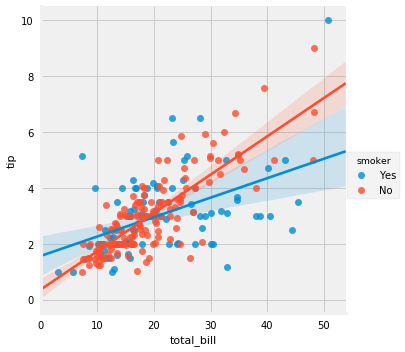

In [78]:
sns.lmplot(x="total_bill", y="tip", hue='smoker', data=tips);

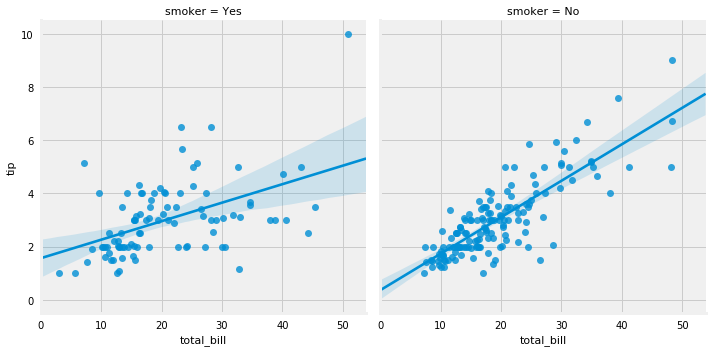

In [79]:
sns.lmplot(x="total_bill", y="tip", col="smoker", data=tips);